In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style('whitegrid')

## Load and default preprocessing

In [18]:
# load data
with open('../witt_preprocessing/pickles/dangjin_merged.pkl','rb') as f:
    dangjin_data = pickle.load(f)
with open('../witt_preprocessing/pickles/ulsan_merged.pkl','rb') as f:
    ulsan_data = pickle.load(f)


# preprocess data for modeling

# time as index
dangjin_data.set_index('time', inplace=True)
ulsan_data.set_index('time', inplace=True)

# dangjin - sum target values
dangjin_data['dangjin_sum'] = dangjin_data['dangjin'] + dangjin_data['dangjin_floating'] + dangjin_data['dangjin_warehouse']
dangjin_data.drop(columns=['dangjin','dangjin_floating','dangjin_warehouse'], inplace=True)

## no-zero

In [19]:
# delete rows where target == 0
dangjin_data = dangjin_data.loc[dangjin_data['dangjin_sum'] != 0]
ulsan_data =  ulsan_data.loc[ulsan_data['ulsan'] != 0]

## Functions

In [31]:
def validate(model, data, x_cols, y_cols, test_size=0.2):
    '''
    model: sklearn model
    data: pd.DataFrame
    x_cols: list
    y_col: list
    test_size = float or int
    '''
    print('x_cols:',x_cols)

    # input-target split
    x = data.loc[:,x_cols]
    y = data.loc[:,y_cols]

    # train-test split
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_size, shuffle=False)

    # fit and predict
    model.fit(train_x, train_y)
    predict = model.predict(test_x)

    return predict, test_y

In [21]:
def evaluate(predict, y):
    return abs(predict - y.iloc[:,0]).mean(axis=0)

## X and Y

In [30]:
x_cols_fcst = ['Temperature_fcst','Humidity_fcst','Cloud_fcst','Day_cos','Day_sin','Year_cos','Year_sin']
x_cols_obs = ['Temperature_obs', 'Humidity_obs','Cloud_obs','Day_cos','Day_sin','Year_cos','Year_sin']

y_dangjin_cols = ['dangjin_sum']
y_ulsan_cols = ['ulsan']

## Train & Plot

In [23]:
# window (for plot)
def window(predict, target, window_start=0, window_size=None):

    if window_size: # if window_size given, slice data
        if (window_start + window_size) > (predict.size + 1): # if window exceeds the data
            predict_sample = predict[window_start:]
            target_sample = target[window_start:]   
        else:
            predict_sample = predict[window_start : window_start + window_size]
            target_sample = target[window_start : window_start + window_size]

    else: # if window_size not given, use the whole data
        predict_sample = predict
        target_sample = target

    return predict_sample, target_sample    

In [34]:
RS = 22

In [35]:
# single rf model
model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, random_state=RS, min_samples_leaf=4)

predict, test_y = validate(model, dangjin_data, x_cols_fcst, y_dangjin_cols)

x_cols: ['Temperature_fcst', 'Humidity_fcst', 'Cloud_fcst', 'Wind_X_fcst', 'Wind_Y_fcst', 'Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
<ipython-input-31-9a990d156c6a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_x, train_y)


In [36]:
evaluate(predict, test_y) 
# current best: 
# train-obs_min-leaf-4 / 141.34
# train-fcst_min-leaf-4 / 196.0x

197.60552153400565

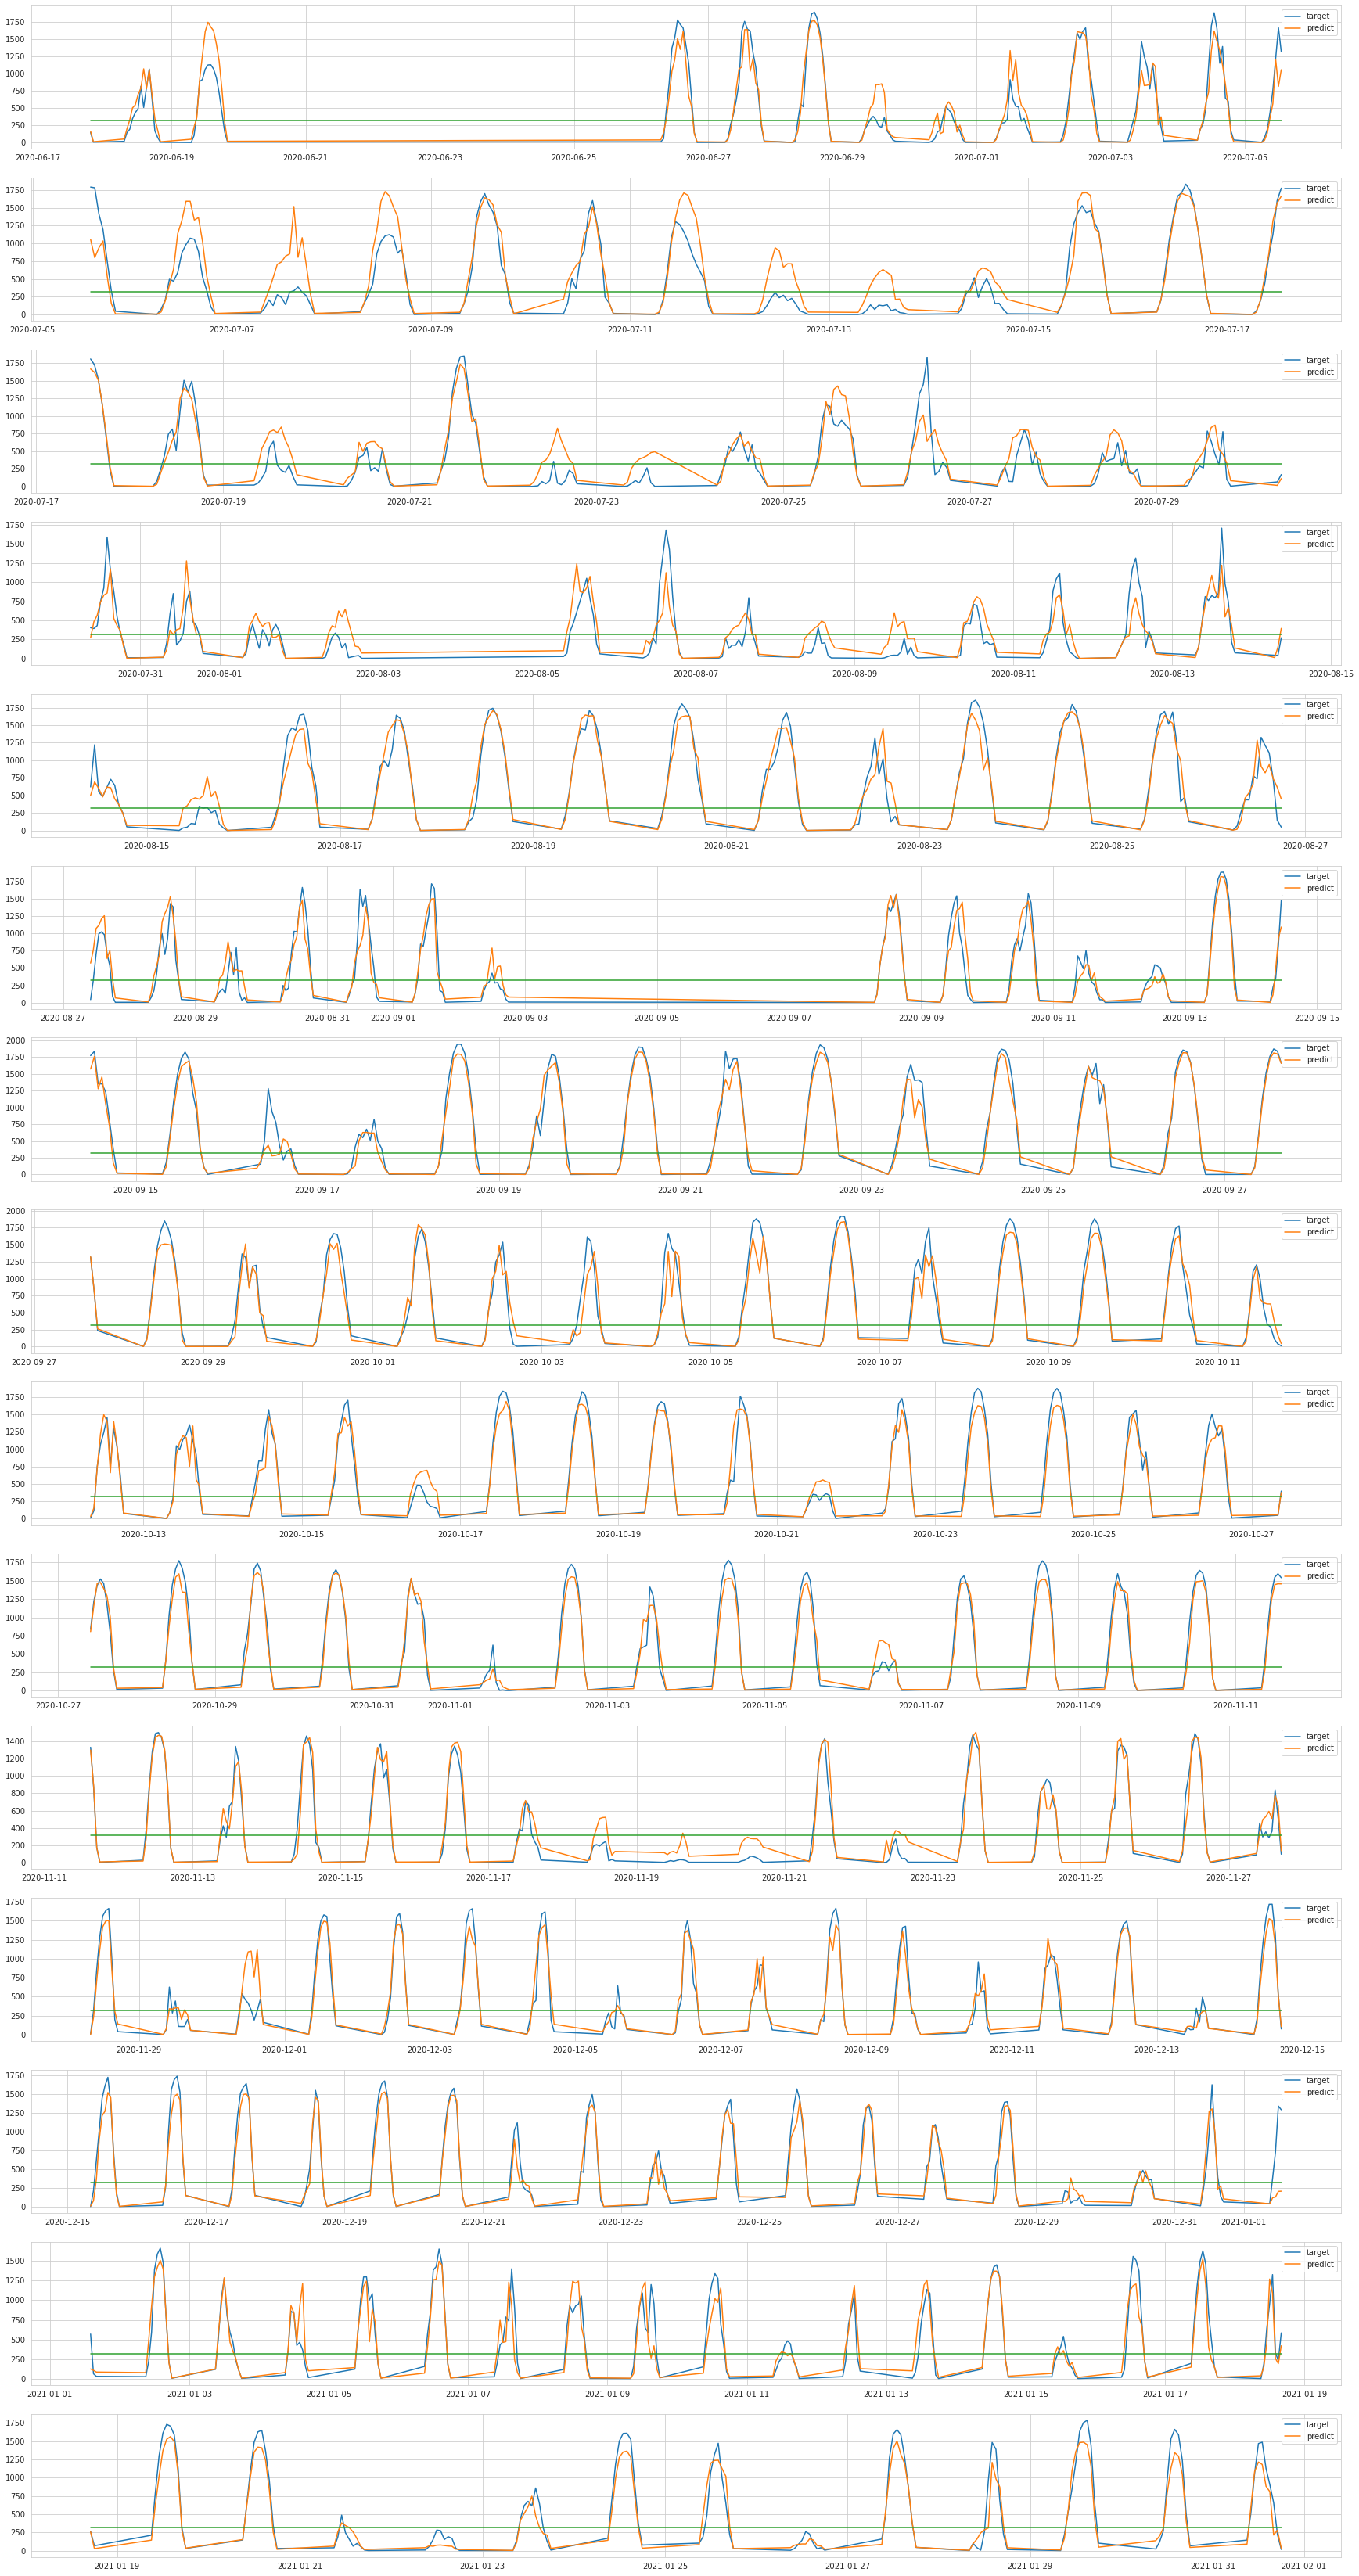

In [13]:
N = 15
fig, ax = plt.subplots(N,1, figsize=(30,4*N))

for n in range(N):
    predict_sample, target_sample = window(predict, test_y, window_start=24*7*n, window_size=24*7)

    ax[n].plot(target_sample, label='target')
    ax[n].plot(pd.Series(predict_sample, index=target_sample.index), label='predict')
    ax[n].plot(target_sample.index, [320 for _ in target_sample.index])
    ax[n].legend()
plt.show()

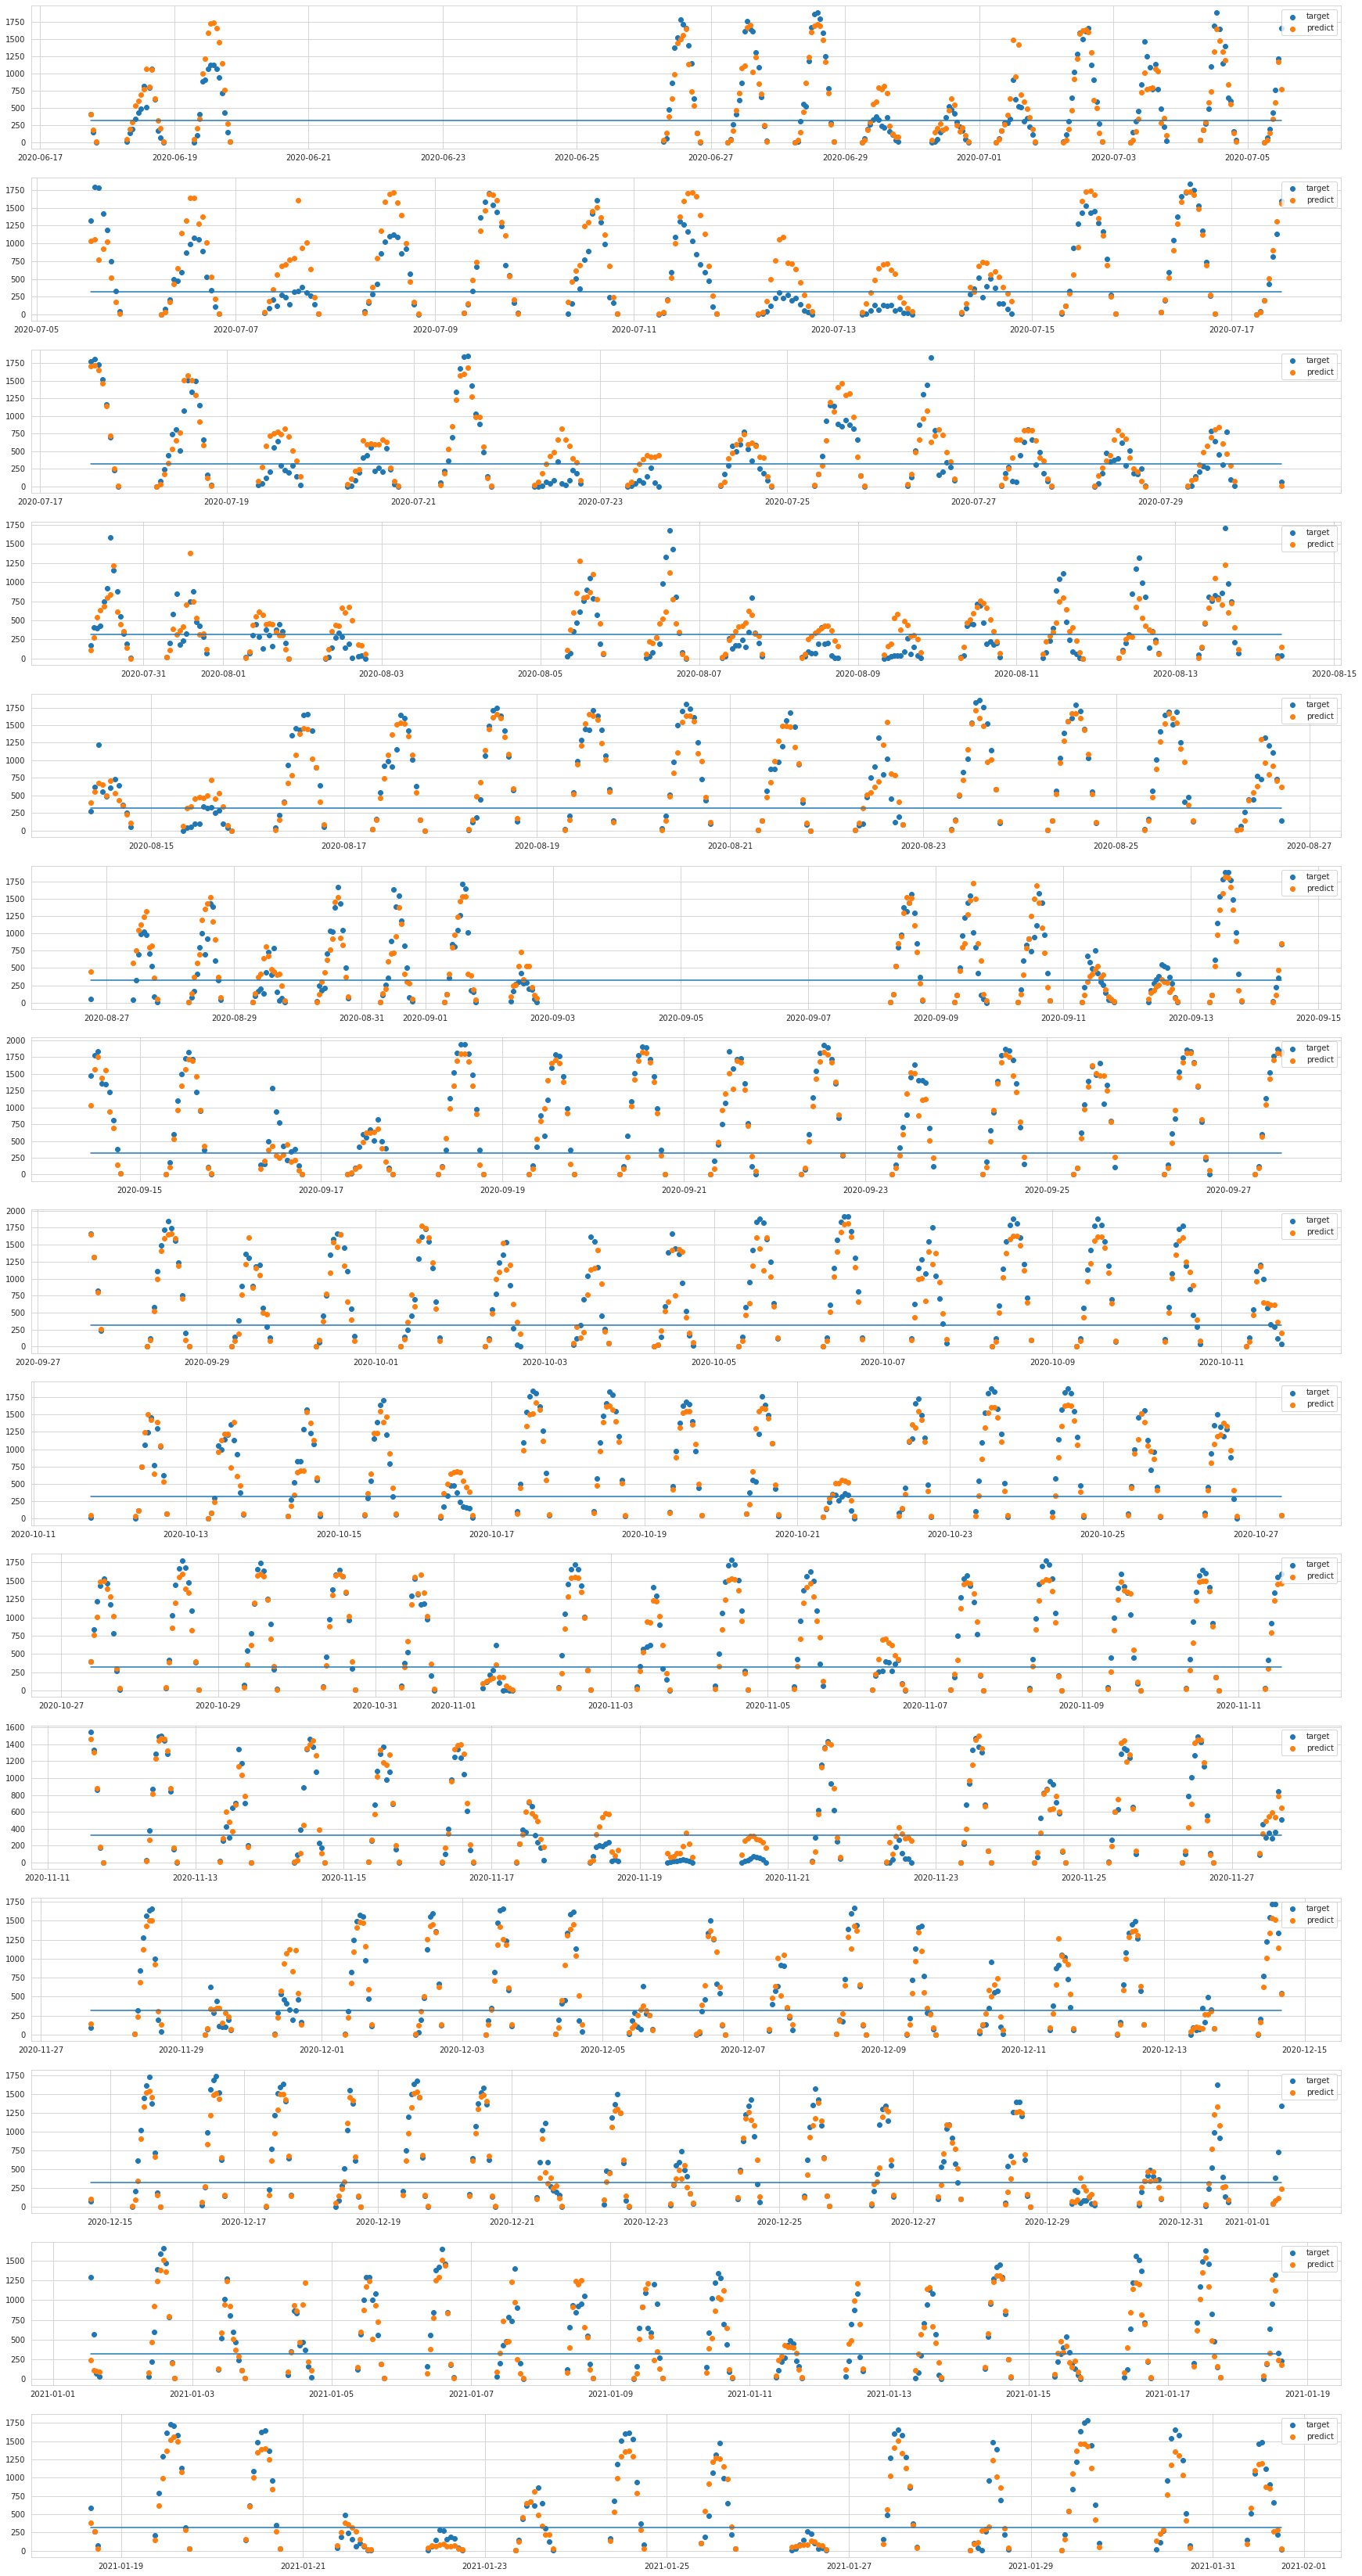

In [56]:
N = 15
fig, ax = plt.subplots(N,1, figsize=(30,4*N))

for n in range(N):
    predict_sample, target_sample = window(predict, test_y, window_start=24*7*n, window_size=24*7)
    ax[n].scatter(target_sample.index, target_sample, label='target')
    ax[n].scatter(target_sample.index, predict_sample, label='predict')
    ax[n].plot(target_sample.index, [320 for _ in target_sample.index])
    ax[n].legend()
    #ax[n].grid(which='both', axis='x')
plt.show()

# problem?: does not predict on night time

## Error by time

In [57]:
test_y_err = test_y.copy()

test_y_err['predict'] = predict
test_y_err['error'] = abs(test_y_err['dangjin_sum'] - test_y_err['predict'])
#test_y_err['error(%)'] = test_y_err['error'] / test_y_err['dangjin_sum']
test_y_err['hour'] = test_y_err.index.hour 

test_y_err.groupby('hour').mean() # 12시와 15시

,dangjin_sum,predict,error
hour,,,
6,3.153846,4.247692,3.112308
7,19.208311,16.098111,13.777800
8,88.832711,85.274858,38.085351
9,268.864248,267.899418,88.500883
10,573.750783,557.819687,146.615321
11,849.435877,837.618168,199.977781
12,1073.807708,1075.788535,220.388801
13,1180.515957,1132.344070,220.002073
14,1134.924199,1138.461023,220.246060


## HP tuning

In [ ]:
# Hp tuning (min_samples_leaf)
msl_list = np.arange(3,8,step=1) # hp(min_samples_leaf) list
ITER = 3

# dictionary to store errors
error_by_msl = {x:[] for x in msl_list}

# loop over msl
for msl in msl_list:
        # iter
    for i in range(ITER):
        print('min_samples_leaf:',msl,'iter:',i) 
        model = RandomForestRegressor(criterion='mae', verbose=0, n_jobs=-1, n_estimators=100, min_samples_leaf=msl)

        predict, test_y = validate(model, dangjin_data, x_cols_obs, y_dangjin_cols)

        error_by_msl[msl].append(evaluate(predict, test_y))

error_by_msl = pd.DataFrame(error_by_msl)
error_by_msl.loc['mean',:] = error_by_msl.mean(axis=0)

error_by_msl

In [ ]:
## Experiment: Hp tuning 
> min_samples_leaf alone
- 4- 6- 5- 7-
- 6- 4- 5- 7-

> max_depth alone
- np.arange(20,45,step=5)
- min = 3866xx
- => better to use other hps

> 